#Разведочный анализ данных. Abalone

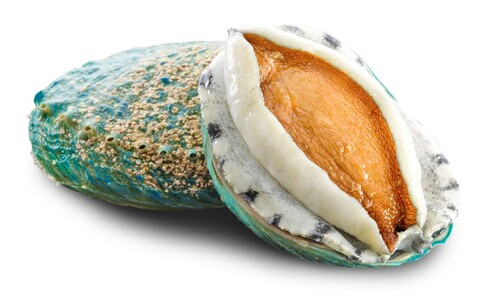

## Импорт библиотек и создание датасета

In [2]:
!pip install association_metrics

  Preparing metadata (setup.py) ... done
  Created wheel for association_metrics: filename=association_metrics-0.0.1-py3-none-any.whl size=3930 sha256=d824de3edf2c199f087b1d55b75d39831dc677760da671c5c0e4b069e30c2b9d
  Stored in directory: /root/.cache/pip/wheels/01/47/5f/4360ef6988df6f1b0c1857cab43334269110160bd97b716936
Successfully built association_metrics


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import association_metrics as am
from scipy.stats import f_oneway
import polars as pl
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


url = 'https://raw.githubusercontent.com/aiedu-courses/eda_and_dev_tools/main/datasets/abalone.csv'
df = pd.read_csv(url)

## Описание данных

*   `Sex` — пол морского ушка (M, F, I)
*   `Length` — длина морского ушка (самое длинное измерение)
*   `Diameter` — диаметр морского ушка (перпендикулярен отрезку, по которому измеряется длина)
*   `Height` — высота морского ушка
*   `Whole weight` — вес морсого ушка
*   `Shucked weight` — вес моркого ушка без ракушки
*   `Viscera weight` — вес кишечника (после кровопотери)
*   `Shell weight` — вес моркого ушка после сушки
*   `Rings` — количество колец (`Rings` + 1.5 равен возрасту)

Добавим столбец `Age`, равный `Rings` + 1.5, — он и будет нашей целевой переменной

In [4]:
df['Age'] = df['Rings'] + 1.5
del df['Rings']

## Исследование данных

Размер датасета

In [5]:
df.shape

(4177, 9)

Количество столбцов

In [6]:
df.columns.size

9

Количество пропусков в датасете

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4078 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4078 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4127 non-null   float64
 8   Age             4177 non-null   float64
dtypes: float64(8), object(1)
memory usage: 293.8+ KB


Можно заметить, что в колонке `Non-Null Count` не все значения равны количеству строк в датасете (4177), значит в некоторых колонках исходного датасета есть пропуски. Для этого нужно найти такие колонки и обработать пропущенные в них значения

In [8]:
df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
count,4177.000000,4078.000000,4177.000000,4078.000000,4177.000000,4177.000000,4127.000000,4177.000000
mean,0.523992,0.407840,0.139516,0.827306,0.359367,0.180594,0.239072,11.433684
std,0.120093,0.099286,0.041827,0.490348,0.221963,0.109614,0.138942,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,2.500000
25%,0.450000,0.350000,0.115000,0.440500,0.186000,0.093500,0.130000,9.500000
50%,0.545000,0.425000,0.140000,0.798500,0.336000,0.171000,0.235000,10.500000
75%,0.615000,0.480000,0.165000,1.150875,0.502000,0.253000,0.328250,12.500000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,30.500000


В столбце Height минимальный рост 0, что не может быть правдой. Заменим такие значения роста медианой

In [9]:
df.Height.replace(0, df.Height.median(), inplace=True)

## Обработка пропусков и ошибок



Процентное соотношение пропусков и всех значений в столбце для каждого столбца




In [10]:
round(df.isnull().mean() * 100, 2)

Sex               0.00
Length            0.00
Diameter          2.37
Height            0.00
Whole weight      2.37
Shucked weight    0.00
Viscera weight    0.00
Shell weight      1.20
Age               0.00
dtype: float64

Распределение для каждого числового столбца

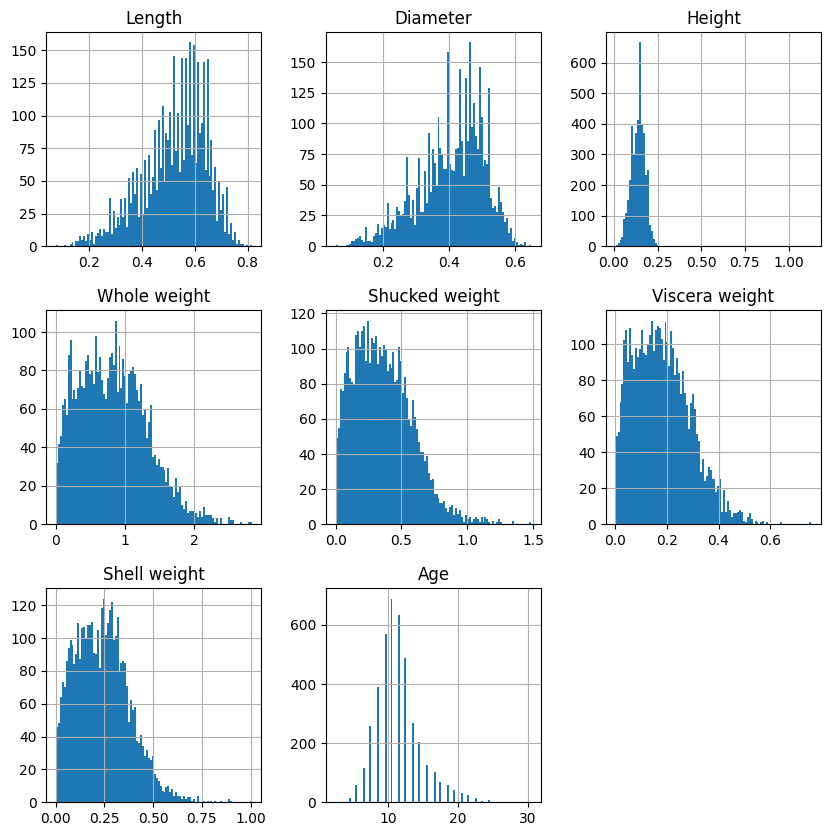

In [11]:
df.hist(bins=100, figsize=(10, 10));

Из запроса выше видно, что в трёх столбцах есть пропуски:

*   `Diameter`: 2.37%
*   `Whole weight`: 2.37%
*   `Shell weight`: 1.20%

Так как пропусков доволно мало, их можно заменить медианой

In [12]:
median_diameter = df['Diameter'].median()
median_whole_weight = df['Whole weight'].median()
median_shell_weight = df['Shell weight'].median()

df.fillna({'Diameter': median_diameter}, inplace=True)
df.fillna({'Whole weight': median_whole_weight}, inplace=True)
df.fillna({'Shell weight': median_shell_weight}, inplace=True)

Значения, которые хранятся в единственном категориальном столбце Sex

Text(0.5, 1.0, 'Sex - Count')

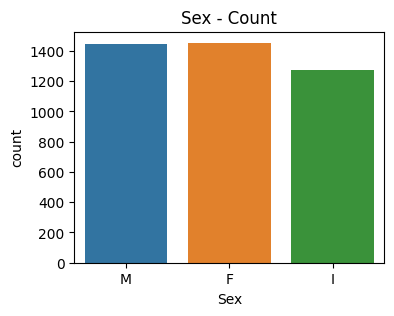

In [21]:
plt.figure(figsize=(4,3))

sns.countplot(x='Sex', data=df, hue='Sex', legend=False)
plt.title('Sex - Count')

Значение f ошибочно, его следует исправить на F

In [14]:
df['Sex'] = df['Sex'].replace('f', 'F')

Проверка на наличение дубликатов

In [15]:
any(df.duplicated())

False

## Взаимозависимость в данных

Корреляция Пирсона

Text(0.5, 1.0, 'Pearson correlation coefficient')

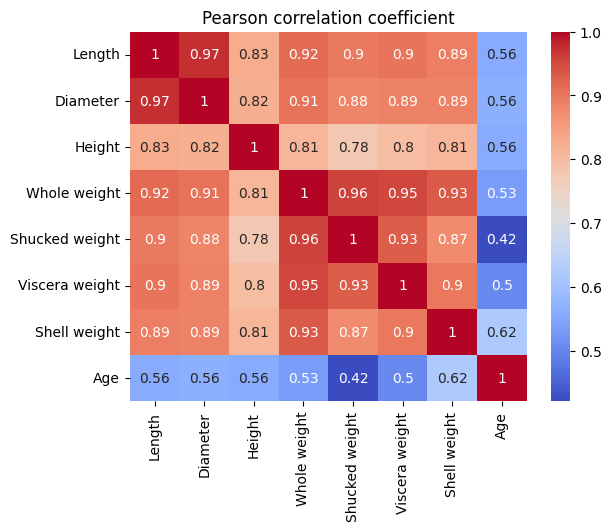

In [16]:
corr_p = df.corr(numeric_only=True)

sns.heatmap(corr_p, annot=True, cmap='coolwarm')
plt.title('Pearson correlation coefficient')


Корреляция Спирмена

Text(0.5, 1.0, "Spearman's rank correlation coefficient")

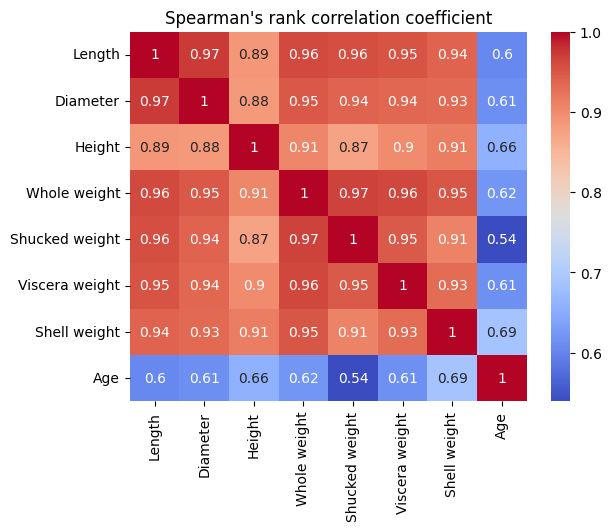

In [18]:
corr_s = df.corr(numeric_only=True, method='spearman')

sns.heatmap(corr_s, annot=True, cmap='coolwarm')
plt.title("Spearman's rank correlation coefficient")

Корреляция Кендалла

Text(0.5, 1.0, 'Kendall rank correlation coefficient')

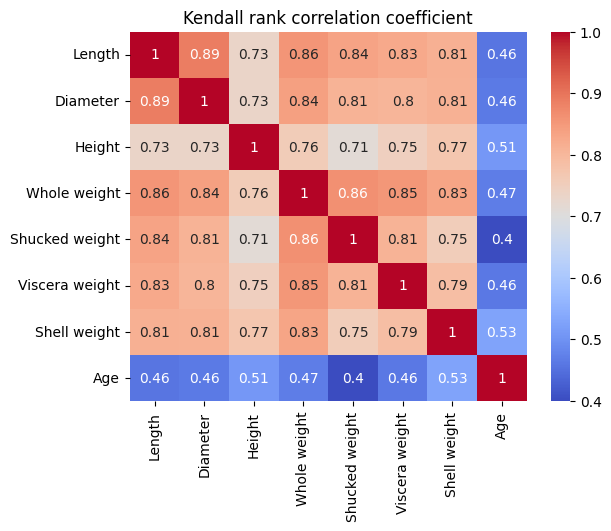

In [19]:
corr_k = df.corr(numeric_only=True, method='kendall')

sns.heatmap(corr_k, annot=True, cmap='coolwarm')
plt.title('Kendall rank correlation coefficient')

Из результатов выше, мы можем сделать вывод, что целевая переменная `Age` слабее всего коррелирует со столбцом `Shucked weight` и сильнее всего с `Shell weight`. Вообще, целевая переменная коррелирует с остальными столбцами довольно слабо по сравнению с тем, как сильно другие столбцы коррелирует друг с другом

В данном датасете один категориальный столбец (Sex), поэтому считать V-меру Крамера или вычислять $\chi^2$ нет смысла

ANOVA (связь между числовыми и категориальными столбцами)

In [ ]:
final_result = {'Category': ['Sex'] * (df.columns.size - 1),
                'Numerical': df.columns[df.columns != 'Sex'],
                'Is correlated': []}
grouped = df.groupby('Sex')

for column in final_result['Numerical']:
    AnovaResults = f_oneway(*grouped[column].apply(list))

    final_result['Is correlated'].append(['Yes', 'No'][bool(AnovaResults[1] >= .05)])

AnovaRes = pd.DataFrame.from_dict(final_result)
AnovaRes

,Category,Numerical,Is correlated
0,Sex,Length,Yes
1,Sex,Diameter,Yes
2,Sex,Height,Yes
3,Sex,Whole weight,Yes
4,Sex,Shucked weight,Yes
5,Sex,Viscera weight,Yes
6,Sex,Shell weight,Yes
7,Sex,Age,Yes


Как видно из теста выше, единственный категориальный столбец Sex исходного датасета коррелирует со всеми остальными числовыми столбцами

## Анализ целевой переменной

Text(0.5, 1.0, 'Age - Count')

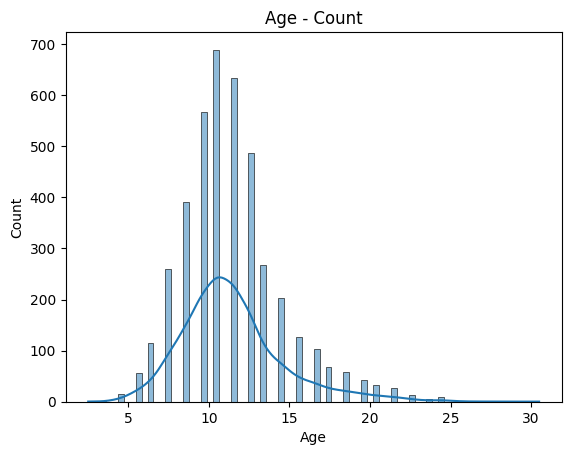

In [20]:
sns.histplot(data=df['Age'], kde=True)
plt.title('Age - Count')

По гистограмме целевой переменной можно заметить, что она имеет нормальное распределение, скошенное вправо. Недостаток такого распределения в том, что в правой части гистограммы мало значений, следовательно, их будет трудно спрогнозировать моделями

Обучим линейную регрессию предсказывать возраст морского ушка по его весу после сушки

In [ ]:
X = df[['Shell weight']]
y = df['Age']

In [ ]:
lr = LinearRegression()
lr.fit(X, y)

prediction = lr.predict(X)

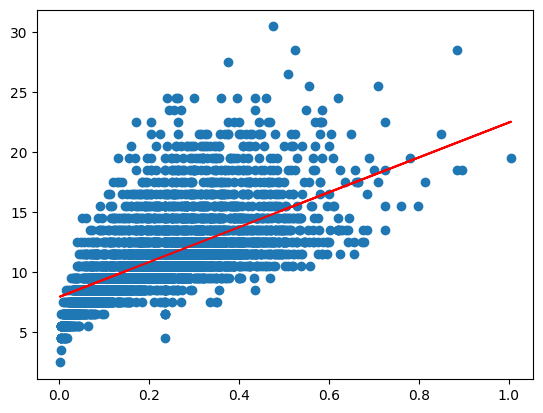

In [ ]:
plt.scatter(X.values, y)
plt.plot(X.values, prediction, c='red')

Вычислим среднюю абсолютную ошибку модели

In [ ]:
mean_absolute_error(y, pred)

1.8381507644109205

In [ ]:
np.mean(y)

11.433684462532918

Как мы видим, ошибка, в сравнении со средним значением целевой переменной, довольно мала

Теперь посчитаем ошибки для значений целевой переменной больше 17, то есть из хвоста гистограммы, и для значений меньше 17

In [ ]:
mean_absolute_error(y[y <= 17], pred[y <= 17])

1.5511691376635737

In [ ]:
mean_absolute_error(y[y > 17], pred[y > 17])

6.143974712083757

Ошибка для значений из хвоста примерно в 3.96 раза больше, чем для остальных значений

##Pandas vs Polars

Сравним скорость выполнения базовый операций: загрузку, фильтрацию, агрегацию данных — на исходном датасете. Чтобы получить более объективные результаты, увеличим количество строк в датасете до одного миллиона

In [ ]:
extended_df = df.copy()

while extended_df.shape[0] < 1_000_000:
    extended_df = pd.concat([extended_df, extended_df])

extended_df.to_csv('extended_dataset.csv', index=False)

In [ ]:
extended_df.shape

(1069312, 10)

###Загрузка данных

In [ ]:
%%time
#Pandas

df_pd = pd.read_csv('extended_dataset.csv')

CPU times: user 846 ms, sys: 59 ms, total: 905 ms
Wall time: 900 ms


In [ ]:
%%time
#Polars

df_pl = pl.read_csv('extended_dataset.csv')

CPU times: user 786 ms, sys: 247 ms, total: 1.03 s
Wall time: 555 ms


###Выбор и фильтрация данных

In [ ]:
%%time
#Pandas

df_pd[['Sex', 'Shell weight']]

CPU times: user 17 ms, sys: 0 ns, total: 17 ms
Wall time: 18.7 ms


,Sex,Shell weight
0,M,0.1500
1,M,0.0700
2,F,0.2100
3,M,0.1550
4,I,0.0550
...,...,...
1069307,F,0.2490
1069308,M,0.2605
1069309,M,0.3080
1069310,F,0.2960


In [ ]:
%%time
#Polars

df_pl[['Sex', 'Shell weight']]

CPU times: user 105 µs, sys: 0 ns, total: 105 µs
Wall time: 110 µs


Sex,Shell weight
str,f64
"""M""",0.15
"""M""",0.07
"""F""",0.21
"""M""",0.155
"""I""",0.055
"""I""",0.12
"""F""",0.33
"""F""",0.26
"""M""",0.165


In [ ]:
%%time
#Pandas

df[(df['Length'] > .52) & (df['Sex'] == 'M')]

CPU times: user 3.47 ms, sys: 0 ns, total: 3.47 ms
Wall time: 3.3 ms


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Age
27,M,0.590,0.445,0.140,0.9310,0.3560,0.2340,0.2800,12,13.5
28,M,0.605,0.475,0.180,0.9365,0.3940,0.2190,0.2950,15,16.5
29,M,0.575,0.425,0.140,0.8635,0.3930,0.2270,0.2000,11,12.5
30,M,0.580,0.470,0.165,0.9975,0.3935,0.2420,0.3300,10,11.5
70,M,0.555,0.425,0.130,0.7665,0.2640,0.1680,0.2750,13,14.5
...,...,...,...,...,...,...,...,...,...,...
4170,M,0.550,0.430,0.130,0.8395,0.3155,0.1955,0.2405,10,11.5
4171,M,0.560,0.430,0.155,0.8675,0.4000,0.1720,0.2290,8,9.5
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,11.5
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,10.5


In [ ]:
%%time
#Polars

df_pl.filter((pl.col('Length') > .52) & (pl.col('Sex') == 'M'))

CPU times: user 46.4 ms, sys: 6.88 ms, total: 53.3 ms
Wall time: 34.5 ms


Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Age
str,f64,f64,f64,f64,f64,f64,f64,i64,f64
"""M""",0.59,0.445,0.14,0.931,0.356,0.234,0.28,12,13.5
"""M""",0.605,0.475,0.18,0.9365,0.394,0.219,0.295,15,16.5
"""M""",0.575,0.425,0.14,0.8635,0.393,0.227,0.2,11,12.5
"""M""",0.58,0.47,0.165,0.9975,0.3935,0.242,0.33,10,11.5
"""M""",0.555,0.425,0.13,0.7665,0.264,0.168,0.275,13,14.5
"""M""",0.57,0.48,0.175,1.185,0.474,0.261,0.38,11,12.5
"""M""",0.595,0.475,0.14,0.944,0.3625,0.189,0.315,9,10.5
"""M""",0.62,0.51,0.175,1.615,0.5105,0.192,0.675,12,13.5
"""M""",0.595,0.475,0.16,1.3175,0.408,0.234,0.58,21,22.5


### Агрегация данных

In [ ]:
%%time
#Pandas

df_pd.groupby('Sex').agg(MeanHeight=('Height', 'mean'),
                      MedianDiameter=('Diameter', 'median'))

CPU times: user 94.5 ms, sys: 0 ns, total: 94.5 ms
Wall time: 94.7 ms


,MeanHeight,MedianDiameter
Sex,,
F,0.155959,0.455
I,0.108150,0.335
M,0.150847,0.455


In [ ]:
%%time
#Polars

df_pl.group_by('Sex').agg(pl.mean('Height'), pl.median('Diameter'))

CPU times: user 74.7 ms, sys: 33 ms, total: 108 ms
Wall time: 63.5 ms


Sex,Height,Diameter
str,f64,f64
"""F""",0.155959,0.455
"""I""",0.10815,0.335
"""M""",0.150847,0.455


In [ ]:
%%time
#Polars (lazy operations)

q = df_pl.lazy().group_by('Sex').agg(pl.mean('Height'), pl.median('Diameter'))

q.collect()

CPU times: user 70.1 ms, sys: 29.6 ms, total: 99.7 ms
Wall time: 96.5 ms


Sex,Height,Diameter
str,f64,f64
"""F""",0.155959,0.455
"""I""",0.10815,0.335
"""M""",0.150847,0.455


##Вывод

Polars незначительно быстрее выполняеет загрузку и агрегацию данных, однако значительно быстрее выбирает данные из датасета. Pandas же фильтрует данные быстрее Polars